# Predict parent neuron
Using Jasper's idea to predict parent neurons for nuclei, Thank you so much, Jasper.

In [1]:
# libraries 1
import numpy as np
import pyperclip
import pandas as pd
import pyperclip
from cloudvolume import CloudVolume, view, Bbox
from nglui import statebuilder,annotation,easyviewer,parser
from nglui.statebuilder import *
import json
from tqdm import tqdm
import argparse

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import csv
from datetime import datetime
from caveclient import CAVEclient

from tifffile.tifffile import imwrite

sys.path.append(os.path.abspath("../segmentation"))
import authentication_utils as auth
import rootID_lookup as IDlook
sys.path.append(os.path.abspath("../synapses"))
import connectivity_utils

%matplotlib inline

In [2]:
np.random.seed(123)
# read csv file
df = pd.read_csv('../Output/body_info_Aug2021.csv', header=0)
len(df)

17076

# A. Create Neuroglancer links for Nucleus Proofreading
based on https://github.com/bjm5164/rotation_projects/blob/main/statebuilder_examples.ipynb

In [ ]:
# color_column not supported for point annotation
imgTokyo = ImageLayerConfig(name = 'FANC_EM_Tokyo',
                                    source = auth.get_cv_path('Image_Tokyo')['url'])
img = ImageLayerConfig(name = 'FANC_EM',
                                    source = auth.get_cv_path('Image')['url'])
nuc_Aug = ImageLayerConfig(name = 'nuclei_Aug2021',
                                    source = auth.get_cv_path('nuclei_map_Aug2021')['url'])      
nuc_seg_Aug = ImageLayerConfig(name = 'nuclei_Aug2021_seg',
                                    source = auth.get_cv_path('nuclei_seg_Aug2021')['url'])      
nuc_Jul = ImageLayerConfig(name = 'nuclei_Jul2021',
                                    source = auth.get_cv_path('nuclei_map_Jul2021')['url'])      
nuc_seg_Jul = ImageLayerConfig(name = 'nuclei_Jul2021_seg',
                                    source = auth.get_cv_path('nuclei_seg_Jul2021')['url'])   
seg = SegmentationLayerConfig(name = 'FANC_production_segmentation',
                                    # selected_ids_column='nuc_segID',
                                    source = auth.get_cv_path('FANC_production_segmentation')['url'])      


df2 = df.assign(pt_position=[*zip(df.x, df.y, df.z)])
points = PointMapper(point_column='pt_position')
ann = AnnotationLayerConfig(name='nuc_center_Aug', mapping_rules=points, color='#32CB42',active = True,)      
sb = StateBuilder(layers=[imgTokyo, seg, img, nuc_Aug, nuc_seg_Aug, nuc_Jul, nuc_seg_Jul, ann],resolution=[4.3,4.3,45]) # view_kws=view_options

client,token = auth.get_client()

state = json.loads(sb.render_state(df2, return_as='json'))

out =auth.get_cv_path('neuroglancer_base')['url'] + '?json_url={path}{state_id}'.format(path=auth.get_cv_path('json_server')['url'],state_id=client.state.upload_state_json(state))
out
# https://neuromancer-seung-import.appspot.com/?json_url=https://api.zetta.ai/json/692331708447824330
# https://github.com/htem/FANC_auto_recon/blob/main/proofreading/proofreading_utils.py



LINK=[]
k=200
minidfs = [df.loc[i:i+k-1, :] for i in range(0, len(df), k)]
for dftemp in minidfs:
    seg = SegmentationLayerConfig(name = 'FANC_production_segmentation',
                                        # selected_ids_column='nuc_segID',
                                        source = auth.get_cv_path('FANC_production_segmentation')['url'])                                 
    sb = StateBuilder(layers=[imgTokyo, seg, img, nuc, nuc_seg],resolution=[4.3,4.3,45]) # view_kws=view_options
    output = sb.render_state(dftemp) #return_as='html'
    LINK.append(output)

In [ ]:
# https://api.zetta.ai/json/post

In [ ]:
# save into csv
LINK2 = pd.DataFrame(LINK)
LINK2.to_csv('../Output/nuc_links.csv', index=False, header=False)

# B. Test my soma list with other table

In [ ]:
# T1MN_somas test
MNsomas = pd.read_csv('../Output/T1MN_somas.csv', header=0)
MNsomas['pt_root_id'].values

exist = []
no_exist = []
for i in MNsomas['pt_root_id'].values:
    if i in df['body_segID'].values:
        exist.append(i)
    else:
        no_exist.append(i)

print(no_exist)

In [ ]:
check = 648518346486520985
print (MNsomas.loc[MNsomas['pt_root_id'] == check])

In [ ]:
nuc = 648518346481315476
df[df['nuc_segID']==nuc]

# C. Summarize count data

In [ ]:
count = pd.read_csv('../Output/ncount_merged.csv', header=None)
count2 = count.T.dropna()
# len(count2) 
# 15094
count3 = count2.sort_values(by=0)
count4 = count3.astype('int')
count4.columns = ['index', 'count']

In [ ]:
sv_size_thres=4000
chosen = count4.loc[count4['count'] <= sv_size_thres]
chosen['index'].values

In [ ]:
test = df.loc[chosen['index'].values]
test[0:999]
rantest = test.iloc[np.random.choice(len(test), round(len(test)/5), replace=False)]

In [ ]:
# nuclei itself
imgTokyo = ImageLayerConfig(name = 'FANC_EM_Tokyo',
                                    source = auth.get_cv_path('Image_Tokyo')['url'])
img = ImageLayerConfig(name = 'FANC_EM',
                                    source = auth.get_cv_path('Image')['url'])
nuc = ImageLayerConfig(name = 'nuclei(old)',
                                    source = auth.get_cv_path('nuclei_map')['url'])                                    
# volume = SegmentationLayerConfig(name = 'volume_outlines',
#                                    source = auth.get_cv_path('Image')['url'])   

seg = SegmentationLayerConfig(name = 'FANC_production_segmentation',
                                        active = True,
                                        source = auth.get_cv_path('FANC_production_segmentation')['url'],
                                        selected_ids_column='segIDs')                                 
sb = StateBuilder(layers=[imgTokyo, seg, nuc, img],resolution=[4.3,4.3,45]) # view_kws=view_options
output = sb.render_state(rantest, return_as='html')
output

In [ ]:
sv_size_thres=4000
notchosen = count4.loc[count4['count'] > sv_size_thres+2000]
test2 = df.loc[notchosen['index'].values]
test2

In [ ]:
rantest2 = test2.iloc[np.random.choice(len(test2), round(len(test2)/5), replace=False)]
output = sb.render_state(rantest2, return_as='html')
output

# D. Get premotor inputs

In [ ]:
# get premotor inputs
MN = pd.read_csv('../Output/MNs.csv', header=0)
MN

# E. point map

In [ ]:
# color_column not supported for point annotation
imgTokyo = ImageLayerConfig(name = 'FANC_EM_Tokyo',
                                    source = auth.get_cv_path('Image_Tokyo')['url'])
img = ImageLayerConfig(name = 'FANC_EM',
                                    source = auth.get_cv_path('Image')['url'])
nuc_Aug = ImageLayerConfig(name = 'nuclei_Aug2021',
                                    source = auth.get_cv_path('nuclei_map_Aug2021')['url'])      
nuc_seg_Aug = ImageLayerConfig(name = 'nuclei_Aug2021_seg',
                                    source = auth.get_cv_path('nuclei_seg_Aug2021')['url'])      
nuc_Jul = ImageLayerConfig(name = 'nuclei_Jul2021',
                                    source = auth.get_cv_path('nuclei_map_Jul2021')['url'])      
nuc_seg_Jul = ImageLayerConfig(name = 'nuclei_Jul2021_seg',
                                    source = auth.get_cv_path('nuclei_seg_Jul2021')['url'])   
# volume = SegmentationLayerConfig(name = 'volume_outlines',
#                                    source = auth.get_cv_path('Image')['url'])   

seg = SegmentationLayerConfig(name = 'FANC_production_segmentation',
                                    active = True,
                                    source = auth.get_cv_path('FANC_production_segmentation')['url'])

df2 = df.assign(pt_position=[*zip(df.x, df.y, df.z)])
points = PointMapper(point_column='pt_position')
ann = AnnotationLayerConfig(name='nuc_center_Aug', mapping_rules=points, color='#32CB42')      
sb = StateBuilder(layers=[imgTokyo, seg, img, nuc_Aug, nuc_seg_Aug, nuc_Jul, nuc_seg_Jul, ann],resolution=[4.3,4.3,45]) # view_kws=view_options

client,token = auth.get_client()

state = json.loads(sb.render_state(df2, return_as='json'))

out =auth.get_cv_path('neuroglancer_base')['url'] + '?json_url={path}{state_id}'.format(path=auth.get_cv_path('json_server')['url'],state_id=client.state.upload_state_json(state))
out
# https://neuromancer-seung-import.appspot.com/?json_url=https://api.zetta.ai/json/692331708447824330
# https://github.com/htem/FANC_auto_recon/blob/main/proofreading/proofreading_utils.py

In [ ]:
# https://api.zetta.ai/json/post

# F. Descending and Ascending neurons

In [3]:
# read data
left_d = np.fromfile('../Output/da/left_d.bin', dtype=np.int64)
left_a = np.fromfile('../Output/da/left_a.bin', dtype=np.int64)
right_d = np.fromfile('../Output/da/right_d.bin', dtype=np.int64)
right_a = np.fromfile('../Output/da/right_a.bin', dtype=np.int64)

pMN_T1L = pd.read_csv('../Output/da/pMN_T1L.csv', header=0)
pMN_T1R = pd.read_csv('../Output/da/pMN_T1R.csv', header=0)

left_dout = pd.read_csv('../Output/da/left_dout.csv', header=0)
left_aout = pd.read_csv('../Output/da/left_aout.csv', header=0)
right_dout = pd.read_csv('../Output/da/right_dout.csv', header=0)
right_aout = pd.read_csv('../Output/da/right_aout.csv', header=0)

In [4]:
df_temp = pd.concat([pMN_T1L, pMN_T1R], axis=0)
aggregation_functions = {'synapses': 'sum'}
pMN_T1all = df_temp.groupby(df_temp['root_id']).aggregate(aggregation_functions)

In [5]:
def find_T1input(array, threshold=3):
    left = array[np.isin(array, pMN_T1L[pMN_T1L['synapses'] >= threshold]['root_id'].values)]
    right = array[np.isin(array, pMN_T1R[pMN_T1R['synapses'] >= threshold]['root_id'].values)]
    both = np.intersect1d(left, right)
    others = array[np.isin(array,np.unique(np.concatenate((left, right))), invert=True)]

    return np.array([len(both), len(left), len(right), len(others)])/len(array), np.array([len(both), len(left), len(right), len(others)]), both

def find_DANoutput(array, threshold=3):
    left_d = array[np.isin(array, left_dout[left_dout['synapses'] >= threshold]['root_id'].values)]
    left_a = array[np.isin(array, left_aout[left_aout['synapses'] >= threshold]['root_id'].values)]
    right_d = array[np.isin(array, right_dout[right_dout['synapses'] >= threshold]['root_id'].values)]
    right_a = array[np.isin(array, right_aout[right_aout['synapses'] >= threshold]['root_id'].values)]
    both_left = np.intersect1d(left_d, left_a)
    both_right = np.intersect1d(right_d, right_a)
    both_d = np.intersect1d(left_d, right_d)
    both_a = np.intersect1d(left_a, right_a)
    all = np.intersect1d(left_d, left_a, right_d, right_a)
    others = array[np.isin(array,np.unique(np.concatenate((left_d, left_a, right_d, right_a))), invert=True)]

    return np.array([len(all), len(both_a), len(both_d), len(both_left), len(both_right), len(left_d), len(left_a), len(right_d), len(right_a), len(others)])/len(array), np.array([len(all), len(both_a), len(both_d), len(both_left), len(both_right), len(left_d), len(left_a), len(right_d), len(right_a), len(others)])

In [ ]:
# Do Descending and Ascending neurons project into MNs? If they do, how many of them?
# Left descending
Ld, Ld_abs, Ldboth = find_T1input(left_d, threshold=10)
La, La_abs, Laboth = find_T1input(left_a, threshold=10)
Rd, Rd_abs, Rdboth = find_T1input(right_d, threshold=10)
Ra, Ra_abs, Raboth = find_T1input(right_a, threshold=10)

In [ ]:
# Laboth
# https://neuromancer-seung-import.appspot.com/?json_url=https://global.daf-apis.com/nglstate/api/v1/4598740472037376

In [ ]:
g = pd.DataFrame(data=np.vstack([Ld, La, Rd, Ra]),
                                index=['Left descending', 'Left ascending', 'Right descending', 'Right ascending'],
                                columns=['T1L & T1R', 'T1L', 'T1R', 'others'])
plt.figure()
sns.heatmap(g, annot=np.vstack([Ld_abs, La_abs, Rd_abs, Ra_abs]), fmt='d')

In [ ]:
# Then how many MNs receive inputs from Descending and Ascending?
MN = pd.read_csv('../Output/da/MN.csv', header=0)

T1L, T1L_abs = find_DANoutput(MN[MN['name'].str.endswith('T1L')]['pt_root_id'].values, threshold=3)
T1R, T1R_abs = find_DANoutput(MN[MN['name'].str.endswith('T1R')]['pt_root_id'].values, threshold=3)

In [ ]:
g = pd.DataFrame(data=np.vstack([T1L, T1R]),
                                index=['T1L', 'T1R'],
                                columns=['all', 'AN', 'DN', 'left', 'right', 'leftDN', 'leftAN', 'rightDN', 'rightAN', 'others'])
plt.figure()
sns.heatmap(g, annot=np.vstack([T1L_abs, T1R_abs]), fmt='d')

In [ ]:
MNinputs = pd.read_csv('../Output/da/MNinputs.csv', header=0, index_col=0)
DANoutputs = pd.read_csv('../Output/da/DANoutputs.csv', header=0, index_col=0)


In [ ]:
# check

In [ ]:
# T1L
test = MNinputs.loc[MNinputs.index.isin(MN[MN['name'].str.endswith('T1R')]['pt_root_id'].values),]
test = test.sum() # sum
test2 = test.drop(["648518346485926546.1", '648518346499332071.1','648518346502185555.1','648518346494092402.1','648518346481307329.1',"others"], axis=0)
test2 = test2[test2>=10] # more than 10 synapses

A = np.isin(test2.index.values.astype(int), right_d)
sum(A)

In [ ]:
test2

In [ ]:
# left_d
test = DANoutputs.loc[DANoutputs.index.isin(left_d),]
test = test.sum() # sum
test2 = test.drop(["648518346490791971.1", "others"], axis=0)
test2 = test2[test2>=10] # more than 10 synapses

In [ ]:
A

# G. Update soma table

In [ ]:
MN = pd.read_csv('../Output/da/MN.csv', header=0)

In [ ]:
date = '2021-08-26 15:25' # UTC
if date != None:
    dt_date = datetime.strptime(date, '%Y-%m-%d %H:%M')
    timestamp = int(dt_date.timestamp())
else:
    timestamp = None

In [ ]:
print(dt_date.tzinfo)

In [ ]:
MNnew = MN.copy()
cv = auth.get_cv()
xyz = MNnew['pt_position'].str.strip('[]').str.split(',',expand=True)
MNnew['pt_root_id'] = IDlook.segIDs_from_pts_cv(xyz.astype(int).to_numpy(),cv, timestamp=timestamp)

In [ ]:
np.set_printoptions(threshold=sys.maxsize)
MNnew['pt_root_id']
# MNnew['pt_root_id'] - MN['pt_root_id']

In [ ]:
MNnew.to_csv('../Output/MN202108271525.csv', index=False)

# H. DN analsys ver2.

In [6]:
# read data
left_d1 = np.fromfile('../Output/da2new/left_d.bin', dtype=np.int64)
left_a1 = np.fromfile('../Output/da2new/left_a.bin', dtype=np.int64)
right_d1 = np.fromfile('../Output/da2new/right_d.bin', dtype=np.int64)
right_a1 = np.fromfile('../Output/da2new/right_a.bin', dtype=np.int64)

pMN_T1L = pd.read_csv('../Output/da2new/pMN_T1L.csv', header=0)
pMN_T1R = pd.read_csv('../Output/da2new/pMN_T1R.csv', header=0)

In [7]:
# oops d and a was opposite...
left_a = left_d1
left_d = left_a1
right_a = right_d1
right_d = right_a1

print('we have {a} DNs and {b} ANs'.format(a=len(left_d)+len(right_d),b=len(left_a)+len(right_a)))

we have 2374 DNs and 1368 ANs


In [8]:
def find_T1input(array, threshold=3):
    arr2 = array[array['synapses'] >= threshold]['root_id'].values
    left_dpMN = arr2[np.isin(arr2, left_d)]
    left_apMN = arr2[np.isin(arr2, left_a)]
    right_dpMN = arr2[np.isin(arr2, right_d)]
    right_apMN = arr2[np.isin(arr2, right_a)]
    others = arr2[np.isin(arr2,np.unique(np.concatenate((left_dpMN, left_apMN, right_dpMN, right_apMN))), invert=True)]

    return np.array([len(left_dpMN), len(left_apMN), len(right_dpMN), len(right_apMN), len(others)])/len(array), np.array([len(left_dpMN), len(left_apMN), len(right_dpMN), len(right_apMN), len(others)]), left_dpMN, left_apMN, right_dpMN, right_apMN, others

In [9]:
T1L_da, T1L_abs,hoge,hoge,hoge,hoge,hoge = find_T1input(pMN_T1L)
T1R_da, T1R_abs,hoge,hoge,hoge,hoge,hoge = find_T1input(pMN_T1R)

In [10]:
def find_T1input_synapse(array, threshold=3):
    hoge, hoge,left_dpMN, left_apMN, right_dpMN, right_apMN, others = find_T1input(array,threshold=threshold)
    left_dpMNS = array[np.isin(array['root_id'], left_dpMN)]['synapses'].sum()
    left_apMNS = array[np.isin(array['root_id'], left_apMN)]['synapses'].sum()
    right_dpMNS = array[np.isin(array['root_id'], right_dpMN)]['synapses'].sum()
    right_apMNS = array[np.isin(array['root_id'], right_apMN)]['synapses'].sum()
    othersS = array[np.isin(array['root_id'], others)]['synapses'].sum()

    return np.array([left_dpMNS, left_apMNS, right_dpMNS, right_apMNS, othersS])/array['synapses'].sum(), np.array([left_dpMNS, left_apMNS, right_dpMNS, right_apMNS, othersS])

<AxesSubplot:>

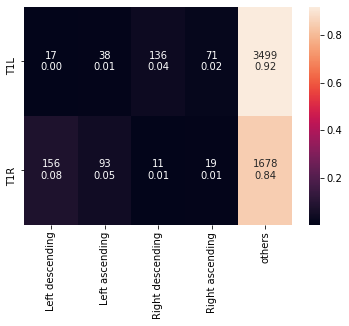

In [12]:
dat = pd.DataFrame(data=np.vstack([T1L_da, T1R_da]),
                                index=['T1L', 'T1R'],
                                columns=['Left descending', 'Left ascending', 'Right descending', 'Right ascending', 'others'])
plt.figure()
labels = (np.asarray(["{0}\n{1:.2f}".format(abs,rel) for abs, rel in zip(np.vstack([T1L_abs, T1R_abs]).flatten(), np.vstack([T1L_da, T1R_da]).flatten())])).reshape(2,5)
sns.heatmap(dat, annot=labels, fmt='')

<AxesSubplot:>

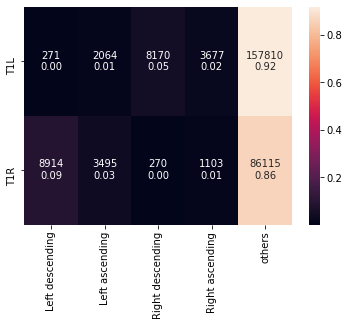

In [13]:
T1L_daS, T1L_absS = find_T1input_synapse(pMN_T1L)
T1R_daS, T1R_absS = find_T1input_synapse(pMN_T1R)

datS = pd.DataFrame(data=np.vstack([T1L_daS, T1R_daS]),
                                index=['T1L', 'T1R'],
                                columns=['Left descending', 'Left ascending', 'Right descending', 'Right ascending', 'others'])
plt.figure()
labels = (np.asarray(["{0}\n{1:.2f}".format(abs,rel) for abs, rel in zip(np.vstack([T1L_absS, T1R_absS]).flatten(), np.vstack([T1L_daS, T1R_daS]).flatten())])).reshape(2,5)
sns.heatmap(datS, annot=labels, fmt='')

In [ ]:
df_concat = pd.concat([pMN_T1L, pMN_T1R]).drop_duplicates(subset=['root_id'])

In [ ]:
T1L_all, T1L_allabs,hoge,hoge,hoge,hoge,hoge = find_T1input(df_concat)
T1L_allS, T1L_allabsS = find_T1input_synapse(df_concat)

In [ ]:
g = pd.DataFrame(data=T1L_all,
                                columns=['T1all'],
                                index=['Left descending', 'Left ascending', 'Right descending', 'Right ascending', 'others'])
plt.figure()
# sns.heatmap(g, annot=np.vstack([T1L_abs, T1R_abs]), fmt='d')
sns.heatmap(g, annot=g)

# I. show chunks

In [ ]:
cv = CloudVolume(auth.get_cv_path('Image')['url'], use_https=True, agglomerate=False) # mip0
np.random.seed(123)
block_x = 256 # block size in mip4 (72x72x45)
block_y = 256
block_z = 256
skip_y = block_y*288 # 73728, this will ignore y < skip_y
thres_s = 0.7 # signal threshold, > threshold to generate nuclei_seg_cv=0.2
thres_x_min = 20 # size threshold for xyz in mip4 (68.8x68.8x45)
thres_y_min = 20 
thres_z_min = 40 
thres_x_max = None
thres_y_max = None
thres_z_max = None
connectivity = 26 # n

In [ ]:

# first centers
start_x = block_x*2**(4-1) + cv.bounds.minpt[0] # (block width)/2 + offset
start_y = block_y*2**(4-1) + cv.bounds.minpt[1]
start_z = block_z*2**(-1) + cv.bounds.minpt[2] 

# array of block centers
centerX = np.arange(start_x, cv.bounds.maxpt[0], block_x*2**4)
centerY = np.arange(start_y + skip_y, cv.bounds.maxpt[1], block_y*2**4)
centerZ = np.arange(start_z, cv.bounds.maxpt[2], block_z)

# cover the final block but keep the size of each block same
centerX = np.append(centerX, cv.bounds.maxpt[0]-start_x)
centerY = np.append(centerY, cv.bounds.maxpt[1]-start_y)
centerZ = np.append(centerZ, cv.bounds.maxpt[2]-start_z)

block_centers = np.array(np.meshgrid(centerX, centerY, centerZ), dtype='int64').T.reshape(-1,3)
len(block_centers)

In [ ]:
A = (block_centers - [block_x*2**4/2, block_y*2**4/2, block_z/2]).astype(int)
B = (block_centers + [block_x*2**4/2, block_y*2**4/2, block_z/2]).astype(int)

In [ ]:
test = pd.DataFrame(data=np.hstack([A,B]), columns=["a", "b","c", "d","e", "f"], dtype='int64')

In [ ]:
test2 = test.assign(A=[*zip(test.a, test.b, test.c)],B=[*zip(test.d, test.e, test.f)])

In [ ]:
test3 = pd.DataFrame(test2[["A", "B"]])
test3 = test3.reindex(columns = test3.columns.tolist() + ["C", "D","E", "F", "G", "H"])

In [ ]:
test3["H"] = "AABB"
test3 = test3.fillna("")

In [ ]:
test3.to_csv("../Output/chunks.csv", index=False, header=False)
test3

# J. Change Log

In [ ]:
client = CAVEclient()
auth = client.auth

In [ ]:
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)
client.info.get_datastack_info()

In [ ]:
ID = 648518346480704480
client.chunkedgraph.get_change_log(root_id=ID, filtered=True)